In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

# Data - Sine Regression Task

In [30]:
from functools import partial


def uniform(shape, min_value, max_value):
    return torch.rand(*shape) * (max_value - min_value) + min_value


class MetaLoader:
    def __init__(self, num_tasks, samples_per_task):
        self.num_tasks = num_tasks
        self.samples_per_task = samples_per_task

    def __iter__(self):
        for ep in range(self.num_tasks):
            A = 0.1 + torch.rand(1) * (5.0 - 0.1)
            p = torch.rand(1) * np.pi
            
            x_supp = -5.0 + torch.rand(self.samples_per_task) * 10.0
            y_supp = A * torch.sin(x_supp - p)

            x_query = -5.0 + torch.rand(self.samples_per_task) * 10.0
            y_query = A * torch.sin(x_query - p)

            yield (x_supp.unsqueeze(1), y_supp.unsqueeze(1)), (x_query.unsqueeze(1), y_query.unsqueeze(1))
    
    def __len__(self):
        return self.num_tasks

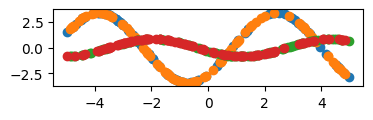

In [40]:
plt.figure(figsize=(4, 1))
for (x, y), (w, z) in MetaLoader(num_tasks=2, samples_per_task=100):
    plt.scatter(x.tolist(), y.tolist())
    plt.scatter(w.tolist(), z.tolist())

# MAML

In [58]:
from torch.func import vmap, grad, functional_call
import torch.nn.functional as F
from torch import optim
import torch


class MAML():
    def __init__(self, model, meta_lr, inner_lr, inner_step, ts_inner_step, iterations, path):
        self.path = path # model checkpoint (for saving or load)

        self.model = model
        self.meta_lr = meta_lr   # beta learning rate in outer loop
        self.inner_lr = inner_lr # alfa learning rate in inner loop
        self.tr_inner_steps = inner_step # optimization step in inner loop during training
        self.all_ts_inner_steps = ts_inner_step # all considered optimization step in inner loop during evaluation
        self.ts_inner_steps = 3 # set 3 for 5-way and set 5 for 20-way : deafault optimization step in inner loop during evaluation
        self.iterations = iterations  # epochs
        self.meta_optimizer = optim.Adam(self.model.parameters(), lr=self.meta_lr)
       
        self.best_loss = 100000  # trackng best loss for model checkpointing

        # Store performance history
        self.tr_history = {"tr_loss" : [], "tr_inner_loss": []}
        self.vl_history = {"vl_loss" : [], "vl_inner_loss": []}
        self.ts_history = {"ts_inner_steps":[], "ts_loss" : [], "ts_inner_loss" : []}

    def _loss(self, y_out, y_true):
        return F.mse_loss(y_out, y_true)
    
    def _inner_loss(self, params, buffers, x, y):
        """functional call to compute loss on the support set"""
        y_out = functional_call(self.model, (params, buffers), x)
        return self._loss(y_out, y)

    def _inner_loop(self, x_support, y_support, x_query, y_query):
        """Single task inner loop training."""
        # needed for functional call
        params = dict(self.model.named_parameters())
        buffers = dict(self.model.named_buffers())

        for _ in range(self.tr_inner_steps):  # inner loop optimization
            grads = grad(self._inner_loss)(params, buffers, x_support, y_support)
            # inner SGD step: params = params - alpha * grad(inner_loss, params)
            params = {k: params[k] - g * self.inner_lr for k, g, in grads.items()}

        # log losses
        supp_loss = self._inner_loss(params, buffers, x_support, y_support)
        query_loss = self._inner_loss(params, buffers, x_query, y_query)
        return supp_loss, query_loss

    def train_episode(self, meta_loader):
        self.model.train()
        meta_loss, inner_loss = 0, 0 
        num_metabatches = len(meta_loader)

        for (x_support, y_support), (x_query, y_query) in meta_loader:           
            num_tasks = x_support.size(dim=0)
            self.meta_optimizer.zero_grad()  # reset meta-gradients

            # inner loop for each task on support loss
            res = vmap(self._inner_loop)(x_support, y_support, x_query, y_query)  # use chunk_size=1 if you get OOM
            all_supp_loss, all_query_loss = res   

            # outer loop on query loss
            all_query_loss.sum().backward()  # meta-gradient of the meta (query) losses
            self.meta_optimizer.step()

            # track total loss and accuracy
            meta_loss += (all_query_loss.detach().sum() / num_tasks).item()
            inner_loss += (all_supp_loss.detach().sum() / num_tasks).item()

        return inner_loss / num_metabatches, meta_loss / num_metabatches

    def evaluation(self, meta_loader):
        self.model.eval()
        query_losses, supp_losses = [], []

        for (x_support, y_support), (x_query, y_query) in meta_loader:
            new_params = dict(self.model.named_parameters())
            buffers = dict(self.model.named_buffers())

            # inner loop optimization
            for _ in range(self.ts_inner_steps):  
                supp_logits = functional_call(self.model, (new_params, buffers), x_support)
                supp_loss = F.mse_loss(supp_logits, y_support)
                grads = torch.autograd.grad(supp_loss, new_params.values())
                new_params = {k: new_params[k] - g * self.inner_lr for k, g, in zip(new_params, grads)}

            # add support loss and accuracy to history
            supp_losses.append(supp_loss.detach())

            # add query loss and accuracy to history
            qry_logits = functional_call(self.model, (new_params, buffers), x_query).detach()
            qry_loss = F.mse_loss(qry_logits, y_query, reduction='none')
            query_losses.append(qry_loss.detach())

        # get mean inner/meta performance over metabatches
        supp_losses = torch.mean(torch.stack(supp_losses)).item()
        query_losses = torch.cat(query_losses).mean().item()
        return supp_losses, query_losses

    def fit_and_evaluate(self, train_loader, eval_loader):
        for iteration in range(self.iterations):
            # train on Train Set (no final retraining on TR+VL) and evaluate on Validation set
            tr_inner_loss, tr_loss = self.train_episode(train_loader)
            vl_inner_loss, vl_loss = self.evaluation(eval_loader)

            # add performance to history
            self.tr_history["tr_loss"].append(tr_loss)
            self.vl_history["vl_loss"].append(vl_loss)
            self.tr_history["tr_inner_loss"].append(tr_inner_loss)
            self.vl_history["vl_inner_loss"].append(vl_inner_loss)

            '''
            (!) Typically Hold-Out Validation technique requires a final retraining on full TR+VL set
            Here final retraining has been not executed due to time constraints
            (Training phase is too time-consuming)
            VL set is still useful for model checkponinting
            '''

            # pretty print
            if iteration % (self.iterations // 10) == 0 or iteration == self.iterations - 1:
                print(
                    f'[Epoch {iteration}] | ',
                    f'[TR] Meta Loss: {tr_loss:.2f} -',
                    f'Inner Loss: {tr_inner_loss:.2f} - |',
                    f'[VL] Meta Loss: {vl_loss:.2f} -  ',
                    f'Inner Loss: {vl_inner_loss:.2f} - |')

                self.model.eval()
                (x_support, y_support), _ = next(iter(eval_loader))
                new_params = dict(self.model.named_parameters())
                buffers = dict(self.model.named_buffers())
                # inner loop optimization
                for _ in range(self.ts_inner_steps):  
                    supp_logits = functional_call(self.model, (new_params, buffers), x_support)
                    supp_loss = F.mse_loss(supp_logits, y_support)
                    grads = torch.autograd.grad(supp_loss, new_params.values())
                    new_params = {k: new_params[k] - g * self.inner_lr for k, g, in zip(new_params, grads)}

                y_out = functional_call(self.model, (new_params, buffers), x_support)
                plt.figure(figsize=(4, 1))
                plt.scatter(x_support.tolist(), y_support.tolist(), label="true")
                plt.scatter(x_support.tolist(), y_out.tolist(), label="pred")
                plt.legend()

            # model checkpointing
            if vl_loss <= self.best_loss:  
                self.best_loss = vl_loss
                torch.save({
                    'epoch': iteration,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.meta_optimizer.state_dict(),
                    'loss': vl_loss,
                }, self.path)

        return self.tr_history, self.vl_history

    def test(self, more_ts_inner_step=True):
        # load best model from checkpoint
        checkpoint = torch.load(self.path)
        self.model.load_state_dict(checkpoint['model_state_dict'])

        # BUG: not needed here???
        self.meta_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        if more_ts_inner_step:  # Make inference with different number of inner step
            for innerstep in self.all_ts_inner_steps:
                self.ts_inner_steps = innerstep
                for _ in range(10): # Make inference 10 times
                    # make inference
                    ts_inner_loss, ts_inner_acc, ts_loss, ts_acc = self.evaluation(mode_eval ="test")

                    # save test performance
                    self.ts_history["ts_inner_steps"].append(self.ts_inner_steps)
                    self.ts_history["ts_loss"].append(ts_loss)
                    self.ts_history["ts_accuracy"].append(ts_acc)
                    self.ts_history["ts_inner_loss"].append(ts_inner_loss)
                    self.ts_history["ts_inner_accuracy"].append(ts_inner_acc)

            return self.ts_history
        else: # make inference just for default ts_inner_step
            ts_inner_loss, ts_inner_acc, ts_loss, ts_acc = self.evaluation(mode_eval ="test")

            # show test performance
            print(
                f'inner-step: {self.ts_inner_steps}|',
                f'Meta-Test Loss: {ts_loss:.2f} | Meta-Test accuracy: {ts_acc:.2f} | ',
                f'Inner-Test Loss: {ts_inner_loss:.2f} | Inner-Test Acc: {ts_inner_acc:.2f} | '
                    )


# Run Experiment

[Epoch 0] |  [TR] Meta Loss: 8.97 - Inner Loss: 0.47 - | [VL] Meta Loss: 4.18 -   Inner Loss: 4.06 - |
[Epoch 100] |  [TR] Meta Loss: 3.85 - Inner Loss: 1.52 - | [VL] Meta Loss: 3.73 -   Inner Loss: 3.79 - |
[Epoch 200] |  [TR] Meta Loss: 2.92 - Inner Loss: 1.30 - | [VL] Meta Loss: 3.60 -   Inner Loss: 3.33 - |
[Epoch 300] |  [TR] Meta Loss: 5.12 - Inner Loss: 1.44 - | [VL] Meta Loss: 2.21 -   Inner Loss: 2.14 - |
[Epoch 400] |  [TR] Meta Loss: 2.08 - Inner Loss: 1.04 - | [VL] Meta Loss: 2.12 -   Inner Loss: 1.77 - |
[Epoch 500] |  [TR] Meta Loss: 2.91 - Inner Loss: 1.01 - | [VL] Meta Loss: 2.12 -   Inner Loss: 2.09 - |
[Epoch 600] |  [TR] Meta Loss: 2.72 - Inner Loss: 0.83 - | [VL] Meta Loss: 2.16 -   Inner Loss: 2.64 - |
[Epoch 700] |  [TR] Meta Loss: 2.46 - Inner Loss: 0.52 - | [VL] Meta Loss: 2.59 -   Inner Loss: 2.47 - |
[Epoch 800] |  [TR] Meta Loss: 2.00 - Inner Loss: 0.83 - | [VL] Meta Loss: 2.99 -   Inner Loss: 3.27 - |
[Epoch 900] |  [TR] Meta Loss: 2.11 - Inner Loss: 0.64 - 

TypeError: MAML.test() got multiple values for argument 'more_ts_inner_step'

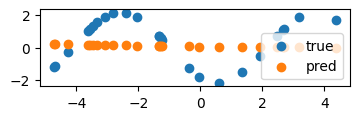

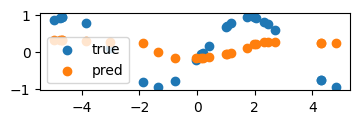

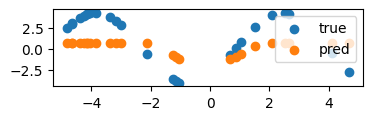

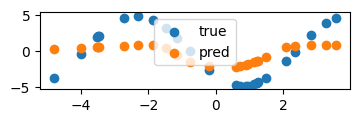

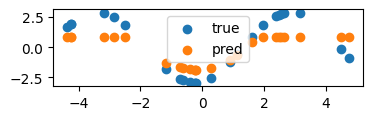

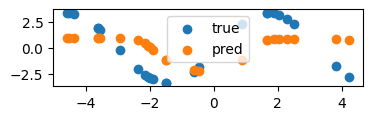

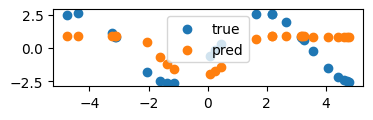

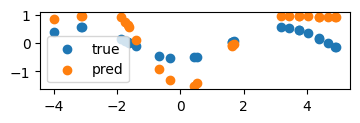

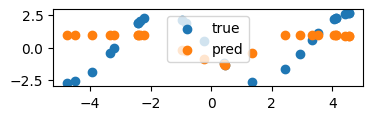

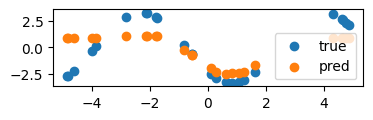

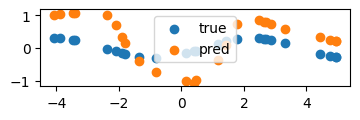

In [59]:
from types import SimpleNamespace
data_root = './logs'
exp_root = './logs'

options = SimpleNamespace(
    dataset_root=data_root,
    meta_lr=1e-3,
    inner_lr=0.01,
    iterations=1000,
    inner_step=10,
    ts_inner_step=[1, 3, 5, 10],
    seed=1,
    device='cpu'
)

model = torch.nn.Sequential(
    torch.nn.Linear(1, 40),
    torch.nn.ReLU(),
    torch.nn.Linear(40, 40),
    torch.nn.ReLU(),
    torch.nn.Linear(40, 40),
    torch.nn.ReLU(),
    torch.nn.Linear(40, 1)
).to(options.device)

maml = MAML(
    model=model,
    meta_lr=options.meta_lr, 
    inner_lr=options.inner_lr, 
    inner_step=options.inner_step, 
    ts_inner_step=options.ts_inner_step, 
    iterations=options.iterations, 
    path=exp_root            
)
train_loader = MetaLoader(num_tasks=10, samples_per_task=25)
test_loader = MetaLoader(num_tasks=10, samples_per_task=25)

tr_history, vl_history = maml.fit_and_evaluate(train_loader, test_loader)
maml.test(test_loader, more_ts_inner_step=False)  # test with default inner steps
ts_history = maml.test(test_loader)  # different inner steps

# Save TRAIN/VAL/TEST performance in csv files
pd.DataFrame(tr_history).to_csv(history_train)
pd.DataFrame(vl_history).to_csv(history_val)
pd.DataFrame(ts_history).to_csv(history_test)

In [48]:
maml.test(test_loader, more_ts_inner_step=False)  # test with default inner steps
ts_history = maml.test(test_loader)  # different inner steps

TypeError: MAML.test() got multiple values for argument 'more_ts_inner_step'